In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
data_dir = "data"
names = ["sps1", "sps2", "sps3", "sps4"]

In [3]:
def calc_stats(x, y) -> dict:
    """Calculates linear resgression of data, fits the data, and calculates
    mae for pre and post calibration
    
    Parameters
    ----------
    x : input
    y : output
    
    Returns
    -------
    dict
        
    """
    
    linreg = stats.linregress(x, y)
    fit = linreg.intercept + x * linreg.slope
    mae_pre = abs(x-y).sum()/len(y)
    mae_post = abs(fit-y).sum()/len(y)
    
    r = {
        "slope": linreg.slope,
        "intercept": linreg.intercept,
        "rvalue": linreg.rvalue,
        "mae_pre": mae_pre,
        "mae_post": mae_posts
    }
    
    return r

In [11]:
I_plots = []
V_plots = []

I_stats_list = []
V_stats_list = []

for n in names:
    # Get filepaths
    csv_path = os.path.join(data_dir, f"{n}.csv")
    yaml_path = os.path.join(data_dir, f"{n}.yaml")
    
    # Load configuration
    with open(yaml_path, "r") as f:
        config = yaml.load(f, Loader=Loader)
    
    # Load data
    data = pd.read_csv(csv_path)
    
    # Convert measured value to correct V/I measurements
    data["I_nom"] = data["V_in"] / config["r_load"] * 1e6
    data["I_calc"] = data["V_current"] / config["r_sense"] / config["gain"] * 1e6
    data["V_meas"] = data["V_2x"] / 2.
    
    # Calculate stats
    I_stats = calc_stats(data["I_calc"], data["I_nom"])
    I_stats["name"] = n
    V_stats = calc_stats(data["V_meas"], data["V_in"])
    V_stats["name"] = n
    
    I_stats_list.append(I_stats)
    V_stats_list.append(V_stats)
    
    # Generate a set of points for fit data
    data["I_fit"] = I_stats["intercept"] + I_stats["slope"] * data["V_meas"]
    data["V_fit"] = V_stats["intercept"] + V_stats["slope"] * data["I_calc"]
    
    I_plots.append(data[["I_nom", "I_calc", "I_fit"]])
    V_plots.append(data[["V_in", "V_meas", "V_fit"]])

In [16]:
I_stats_df = pd.DataFrame(I_stats_list)
I_stats_df.set_index('name')

,slope,intercept,rvalue,mae_pre,mae_post
name,,,,,
sps1,1.053495,-0.215340,0.999997,8.481456,0.215408
sps2,1.047137,-0.108001,0.999995,7.616318,0.247936
sps3,1.049812,-0.604729,0.999945,7.494949,0.584517
sps4,1.048127,-0.120128,0.999997,7.680437,0.208992


In [17]:
V_stats_df = pd.DataFrame(V_stats_list)
V_stats_df.set_index('name')

,slope,intercept,rvalue,mae_pre,mae_post
name,,,,,
sps1,1.001275,-0.002944,0.999990,0.002463,0.000711
sps2,0.999700,-0.005534,0.999447,0.005650,0.004902
sps3,0.999629,-0.003393,0.999945,0.003534,0.001325
sps4,0.995695,-0.001860,0.999997,0.003491,0.000438


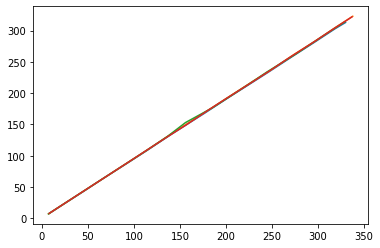

In [5]:
fig, ax = plt.subplots()
for i in I_plots:
    ax.plot(i["I_nom"], i["I_calc"])

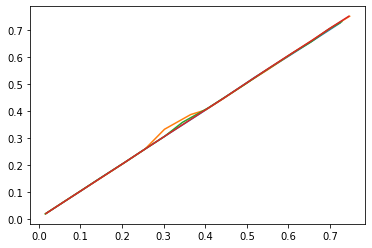

In [6]:
fig, ax = plt.subplots()
for v in V_plots:
    ax.plot(v["V_in"], v["V_meas"])